<a href="https://colab.research.google.com/github/ashikshafi08/Learning_Tensorflow/blob/main/Exercise/%F0%9F%9B%A0_09_Milestone_Project_2_SkimLit_%F0%9F%93%84%F0%9F%94%A5_Exercise_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🛠 09. Milestone Project 2: SkimLit 📄🔥 Exercise Solutions.

> **Note** The orders of the exercise is mixed. 


1. Checkout the [Keras guide on using pretrained GloVe embeddings](https://keras.io/examples/nlp/pretrained_word_embeddings/). Can you get this working with one of our models?
  - Hint: You'll want to incorporate it with a custom token [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer.
  - It's up to you whether or not you fine-tune the GloVe embeddings or leave them frozen.

2. Try replacing the TensorFlow Hub Universal Sentence Encoder pretrained embedding for the [TensorFlow Hub BERT PubMed expert](https://tfhub.dev/google/experts/bert/pubmed/2) (a language model pretrained on PubMed texts) pretrained embedding. Does this effect results?

  - Note: Using the BERT PubMed expert pretrained embedding requires an extra preprocessing step for sequences (as detailed in the [TensorFlow Hub guide](https://tfhub.dev/google/experts/bert/pubmed/2)).
  - Does the BERT model beat the results mentioned in this paper? https://arxiv.org/pdf/1710.06071.pdf. 

3. What happens if you were to merge our `line_number` and `total_lines` features for each sequence? For example, created a `X_of_Y` feature instead? Does this effect model performance?
  - Another example: `line_number=1` and total_lines=11 turns into `line_of_X=1_of_11`.

4. Train `model_5` on all of the data in the training dataset for as many epochs until it stops improving. Since this might take a while, you might want to use:
  - `tf.keras.callbacks.ModelCheckpoint` to save the model's best weights only.
  - `tf.keras.callbacks.EarlyStopping` to stop the model from training once the validation loss has stopped improving for ~3 epochs.

5. Write a function (or series of functions) to take a sample abstract string, preprocess it (in the same way our model has been trained), make a prediction on each sequence in the abstract and return the abstract in the format:
```
PREDICTED_LABEL: SEQUENCE
PREDICTED_LABEL: SEQUENCE
PREDICTED_LABEL: SEQUENCE
PREDICTED_LABEL: SEQUENCE
```
You can find your own unstrcutured RCT abstract from PubMed or try this one from: [Baclofen promotes alcohol abstinence in alcohol dependent cirrhotic patients with hepatitis C virus (HCV) infection.](https://pubmed.ncbi.nlm.nih.gov/22244707/)

## Downloading the data and preprocessing it. 

In [22]:
import tensorflow as tf
from tensorflow.keras import layers 

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [1]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [2]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [3]:
# Create function to read the lines of a document
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [4]:
# Creating a preprocessing function that returns a dictionary
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [5]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") 
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

len(train_samples), len(val_samples), len(test_samples)

CPU times: user 549 ms, sys: 112 ms, total: 661 ms
Wall time: 1.35 s


In [6]:
# Loading our data into a dataframe
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [7]:
# Convert abstract text lines into lists 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [8]:
# One hot encoding the labels 
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [9]:
# Extract labels and encoder them into integers 
from sklearn.preprocessing import LabelEncoder 

label_encoder = LabelEncoder() 

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [10]:
# Get class names and number of classes from LabelEncoder instance 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes , class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))


### 1. Checkout the [Keras guide on using pretrained GloVe embeddings](https://keras.io/examples/nlp/pretrained_word_embeddings/). Can you get this working with one of our models?

In [ ]:
# Loading the pre-trained embeddings 
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

In [12]:
# Getting the path of the glove embedding (using 100D)
import numpy as np 
glove_path = 'glove.6B.100d.txt'

embedding_index = {}

# Making dict of vector representtion of the words (s --> [8, 48......])
with open(glove_path) as f:
  for line in f:
    
    # Getting the words and coef in a variable 
    word , coefs = line.split(maxsplit = 1)
    coefs = np.fromstring(coefs , 'f' , sep = ' ')
    
    # Adding the coefs to our embedding dict 
    embedding_index[word] = coefs

print(f'Found {len(embedding_index)} word vectors')

Found 400000 word vectors


Great we loaded in the data and the next step will be creating a corresponding embedding matrix. So we can fit our `embedding_index` to our Embedding layer. 


In [13]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()

In [14]:
# Creatinga a text vectorizaiton layer 
from tensorflow.keras.layers import TextVectorization 

text_vectorizer = TextVectorization(max_tokens= 68000 , 
                                    output_sequence_length = 55)

# Adapt our text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [15]:
# Getting the vocabulary of the vectorizer 
text_vocab = text_vectorizer.get_vocabulary()
len(text_vocab)

64841

In [16]:
# Getting the dict mapping word --> index 
word_index = dict(zip(text_vocab , range(len(text_vocab))))

In [17]:
# Vectorizer for the character level embedding

# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]


# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation

# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=290,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)


In [18]:
# Getting the vocab len of the character level 
char_vocab = char_vectorizer.get_vocabulary()
len(char_vocab)

28

In [19]:
# Prepariing the embedding matrix for our Embedding layer 

num_tokens = len(text_vocab) + 2 
embedding_dim = 100 
hits = 0 
misses = 0 

# Prepare the embedding matrix 
embedding_matrix = np.zeros((num_tokens , embedding_dim))
for word , i in word_index.items():
  embedding_vector = embedding_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
    hits +=1 
  else:
    misses += 1 

print(f'Converted {hits} words [{misses} misses]')

Converted 29730 words [35111 misses]


In [23]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=True,
                              name="char_embed")

In [24]:
# Adding the embedding matrix to our Embedding layer 
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(num_tokens , 
                            embedding_dim , 
                            embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix) , 
                            trainable = False )

In [25]:
# Creating tf.data pipelines 

# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [26]:
from tensorflow.keras import layers
# Setting up token inputs/model 

token_inputs = layers.Input(shape = [] , dtype = 'string' , name = 'token_inputs')
token_embeddings = embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_glove_embedding")


In [27]:
model.summary()

Model: "model_glove_embedding"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100)          6484300     token_inputs[0][0]               
______________________________________________________________________________

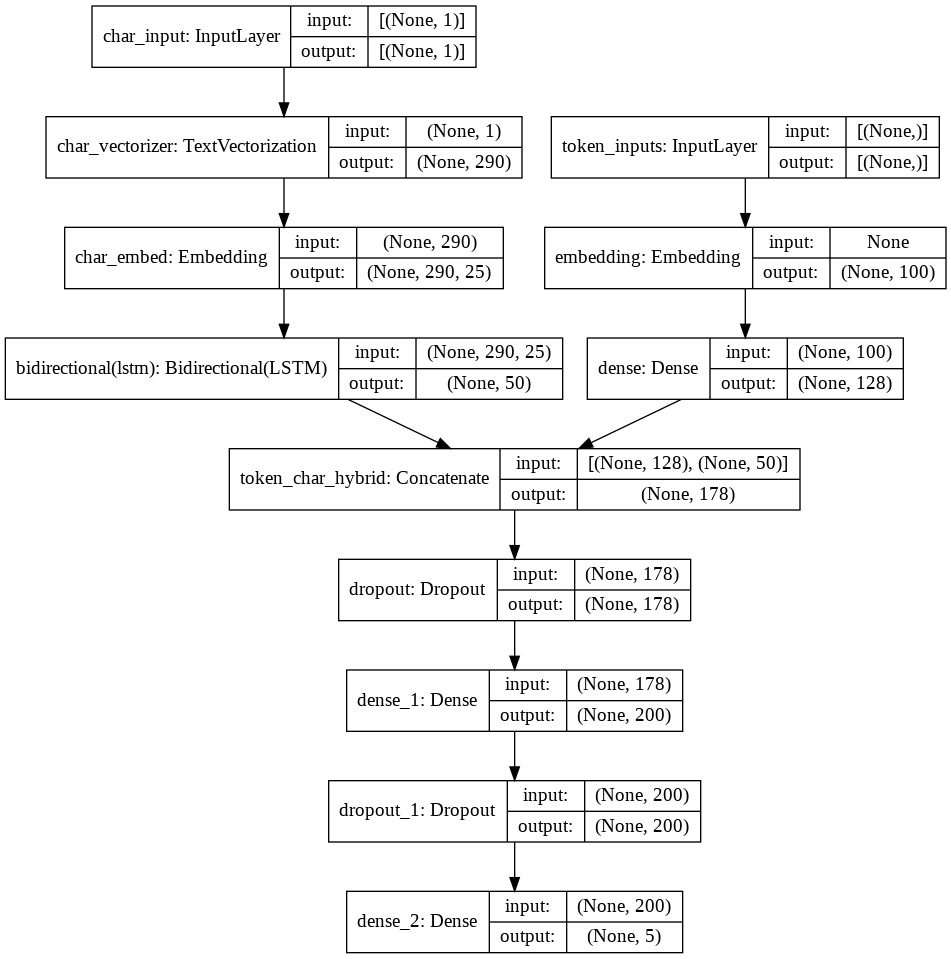

In [28]:
# Plotting the model 
from tensorflow.keras.utils import plot_model
plot_model(model , show_shapes= True )

In [29]:
# Compile the model 
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(), 
              optimizer = tf.keras.optimizers.Adam() , 
              metrics = ['accuracy'])

In [30]:
# Fitting the model 
history = model.fit(train_char_token_dataset , 
                    steps_per_epoch = int(0.1 * len(train_char_token_dataset)) , 
                    epochs = 3 , 
                    validation_data = val_char_token_dataset , 
                    validation_steps = int(0.1 * len(val_char_token_dataset)))

Epoch 1/3


UnimplementedError: ignored